# Recurrent Neural Networks for Machine Translation

The intention of this notebook ist to show implementation, training and use of recurrent neural networks for machine translation.

In [18]:
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

from keras.initializers import Constant
from keras.layers import Embedding, Dense, GRU, Input, Bidirectional, RepeatVector, TimeDistributed
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt

At first, the dataset is loaded. It is split into two files, *small_vocab_en* with 137861 english sentences, and *small_vocab_fr* with the french translation of each sentence.

In [2]:
with open("./data/small_vocab_en.txt") as f:
    en_vocab = f.read()
    
with open("./data/small_vocab_fr.txt") as f:
    fr_vocab = f.read()
    
en_vocab = en_vocab.split('\n')
fr_vocab = fr_vocab.split('\n')

In [3]:
print("Number of english sentences: {}".format(len(en_vocab)))
print("Number of french sentences: {}".format(len(fr_vocab)))
print("\nExample:\n--------")
print("English:", en_vocab[0])
print("French: ", fr_vocab[0])

Number of english sentences: 137861
Number of french sentences: 137861

Example:
--------
English: new jersey is sometimes quiet during autumn , and it is snowy in april .
French:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .


The next step is preprocess the data. The english as well as the french words are tokenized using the Keras Tokenizer. The tokenized sentences are stored to the lists `en_sequences` and `fr_sequences`. Then dictionaries that translate words to tokens and tokens back to words are genereated. A padding term is added to the token-to-word dictionaries because the token "0" is used for padding sentences to the same length but it has no corresponding word in the dataset. Also the function `token_seq_to_french_sentence()` to translate a sequence of tokens back to a french sentence is defined.

In [4]:
MAX_NUM_WORDS = 20000

# tokenize english words
en_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
en_tokenizer.fit_on_texts(en_vocab)
en_sequences = pad_sequences(en_tokenizer.texts_to_sequences(en_vocab), maxlen=None)
max_en_len = en_sequences.shape[1]

# tokenize french words
fr_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
fr_tokenizer.fit_on_texts(fr_vocab)
fr_sequences = pad_sequences(fr_tokenizer.texts_to_sequences(fr_vocab), maxlen=None)
max_fr_len = fr_sequences.shape[1]

# englich word => token dictionary
en_word_to_token = en_tokenizer.word_index
en_word_to_token["<PAD>"] = 0

# token => english word dictionary
en_token_to_word = {}
for word, token in en_word_to_token.items():
    en_token_to_word[token] = word

# french word => token dictionary
fr_word_to_token = fr_tokenizer.word_index
fr_word_to_token["<PAD>"] = 0

# token => french word dictionary
fr_token_to_word = {}
for word, token in fr_word_to_token.items():
    fr_token_to_word[token] = word


def token_seq_to_french_sentence(seq):
    sentence = ""
    for word in [fr_token_to_word[token] for token in seq]:
        sentence = sentence + " " + word
    return sentence

print("Sentence in dataset:\n--------------------\n", fr_vocab[0])
print("\nTokenized sentence:\n-------------------\n", fr_sequences[0])
print("\nFrom token back to sentence:\n-------------------------\n", token_seq_to_french_sentence(fr_sequences[0]))

Sentence in dataset:
--------------------
 new jersey est parfois calme pendant l' automne , et il est neigeux en avril .

Tokenized sentence:
-------------------
 [  0   0   0   0   0   0   0  35  34   1   8  67  37  11  24   6   3   1
 112   2  50]

From token back to sentence:
-------------------------
  <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> new jersey est parfois calme pendant l' automne et il est neigeux en avril


The outputs of the neural translator network are the possibilities for each word in the french vocabulary. Therefore, the french sequences must be one-hot encoded so that they can be used to be compared to the word possibilities put out by the neural network.

In [5]:
fr_sequences = to_categorical(fr_sequences)

print("Shape of en_sequences: {}".format(en_sequences.shape))
print("shape of fr_sequences: {}".format(fr_sequences.shape))

Shape of en_sequences: (137861, 15)
shape of fr_sequences: (137861, 21, 346)


The neural networks used in this notebook use GloVe word embedding. The next step is to load the word vectors from file and prepare the embedding layer. 

In [7]:
# Some parts in this cell are from or inspired by "The Keras Blog: Using
# pre-trained word embeddings in a Keras model",
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

# Load GloVe word vectors
embeddings_index = {}
with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coeffs

print('Loaded {} GloVe word vectors.'.format(len(embeddings_index)))

# Prepare embedding matrix
embedding_dim = embeddings_index["sunday"].shape[0]

num_words = min(MAX_NUM_WORDS, len(en_word_to_token)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in en_word_to_token.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_en_len,
                            trainable=False)

Loaded 400000 GloVe word vectors.


In the following cells, the neural network is defined and trained.

In [10]:
def translator_net(input_seq_len, embed_layer, output_seq_len, output_dim):
    # encoder
    model_input = Input(shape=(input_seq_len,), dtype='int32')
    emb = embed_layer(model_input)
    enc_gru = Bidirectional(GRU(units=256, return_sequences=False))(emb)
    rep = RepeatVector(output_seq_len)(enc_gru)
    # decoder
    dec_gru = GRU(units=256, return_sequences=True)(rep)
    out = TimeDistributed(Dense(output_dim, activation="softmax"))(dec_gru)
    
    model = Model(model_input, out)
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])
    return model

In [11]:
model = translator_net(input_seq_len=max_en_len, embed_layer=embedding_layer,
             output_seq_len=max_fr_len, output_dim=len(fr_token_to_word))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 15)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 15, 100)           20100     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               548352    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 21, 512)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 21, 256)           590592    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 21, 346)           88922     
Total params: 1,247,966
Trainable params: 1,227,866
Non-trainable params: 20,100
_____________________________________________________________

In [12]:
history = model.fit(en_sequences, fr_sequences, validation_split=0.25, shuffle=True,
                    batch_size=1024, epochs=20, verbose=1)

Train on 103395 samples, validate on 34466 samples
Epoch 1/20
103395/103395 [==============================] - 61s 594us/step - loss: 2.5387 - acc: 0.4606 - val_loss: 2.0073 - val_acc: 0.5014
Epoch 2/20
103395/103395 [==============================] - 50s 483us/step - loss: 1.7764 - acc: 0.5360 - val_loss: 1.5902 - val_acc: 0.5709
Epoch 3/20
103395/103395 [==============================] - 50s 480us/step - loss: 1.3837 - acc: 0.6176 - val_loss: 1.2257 - val_acc: 0.6607
Epoch 4/20
103395/103395 [==============================] - 49s 478us/step - loss: 1.4614 - acc: 0.6093 - val_loss: 1.2731 - val_acc: 0.6465
Epoch 5/20
103395/103395 [==============================] - 49s 475us/step - loss: 1.0984 - acc: 0.6931 - val_loss: 1.0075 - val_acc: 0.7169
Epoch 6/20
103395/103395 [==============================] - 49s 477us/step - loss: 0.9515 - acc: 0.7280 - val_loss: 0.9028 - val_acc: 0.7403
Epoch 7/20
103395/103395 [==============================] - 49s 478us/step - loss: 1.1972 - acc: 0.6815

In [15]:
def plot_training_history(history, model_name="model"):
    # Plot training and validation accuracy values
    plt.subplot(121)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Prediction accuracy of {}'.format(model_name))
    plt.ylabel('Accuracy')
    plt.xlabel('Training Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    #plt.show()
    
    # Plot training and validation loss values
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Prediction loss of {}'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Training Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.tight_layout()
    plt.show()

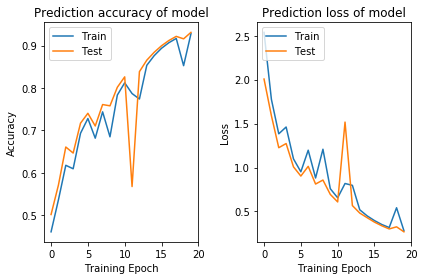

In [19]:
plot_training_history(history)